In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
from scipy.stats import entropy

In [2]:
plt.rcParams["figure.subplot.left"] = 0.18
plt.rcParams["figure.subplot.right"] = 0.95
plt.rcParams["figure.subplot.bottom"] = 0.15
plt.rcParams["figure.subplot.top"] = 0.95
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] ='sans-serif'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = 1.0
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['lines.markersize'] = 4

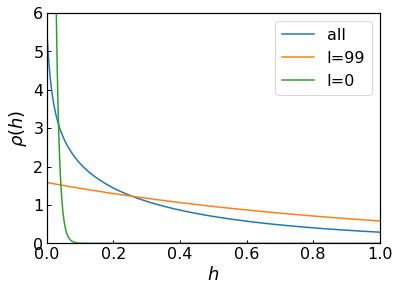

In [3]:
h = np.linspace(0.0, 1.0, num=501)[1::] # exclude the first because it can diverge
h = h - (h[1]-h[0])/2

def _rho_I(h, alpha=1.0, h0=0.3):
    ro = alpha/h0*(h/h0)**(alpha-1) * np.exp( -(h/h0)**alpha )
    dh = h[1]-h[0]
    return ro / (np.sum(ro)*dh)   # normalize

h0_min=0.01
h0_max=1.0
C=100

rho_I = np.zeros( (C, h.shape[0]) )
for I in range(C):
    h0 = h0_min + I*(h0_max-h0_min)/(C-1)
    rho_I[I] = _rho_I(h, h0=h0)
    
rho = np.sum( rho_I, axis=0 ) / C
plt.xlim(0.0,1.0)
plt.ylim(0, 6)
plt.yscale("linear")
plt.xlabel(r"$h$")
plt.ylabel(r"$\rho(h)$")
plt.plot(h, rho, label="all")
plt.plot(h, rho_I[99], label="I=99")
plt.plot(h, rho_I[0], label="I=0")
plt.legend()


1.0000000000000002

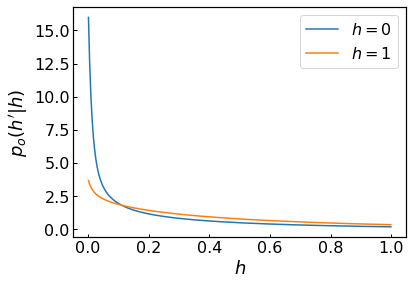

In [4]:
# p_o(h,h') =
# \sum_{I}\rho_{I}(h) [p_{\rm in}N_{C}\rho_{I}(h') + p_{\rm out}(N-N_{C})\sum_{I'\neq I}\rho_{I'}(h')/(C-1) ]
#  / C[p_{\rm in}N_{C}+p_{\rm out}(N-N_{C}])}
def _p_o_hh(h, C=100, N_in=100, p_in=0.5, N_out=9900, p_out=50.0/9900.0, rho_I=rho_I):
    # axis-0,1,2 are hi,hj,I
    nh = h.shape[0]
    hi = h.reshape( (nh,1,1) )
    hj = h.reshape( (1,nh,1) )
    I = np.arange(0, C).reshape( (1,1,C) )      # block index
    
    denom = C*(p_in*N_in + p_out*N_out) # denominator
    rho_I_hj = rho_I.transpose(1,0).reshape( (1,nh,C) )   # rho_{I}(hj)
    rho_I_hi = rho_I.transpose(1,0).reshape( (nh,1,C) )   # rho_{I}(hj)
    sum_rho_hj = np.sum( rho_I_hj, axis=2 ).reshape( (1,nh,1) )
    numer_1 = p_in * N_in * rho_I_hj   # first term of the numerator
    numer_2 = p_out * N_out * (sum_rho_hj-rho_I_hj) / (C-1)
    numer = np.sum( rho_I_hi * (numer_1 + numer_2), axis=2 )
    return numer / denom

# p_o(h'|h)
#   h,h' are axis-0,1
#   = p_o(h,h') / rho(h)
def _p_o_hprime_given_h(h, C=100, N_in=100, p_in=0.5, N_out=9900, p_out=50.0/9900.0, rho_I=rho_I):
    # axis-0,1 are hi,hj
    nh = h.shape[0]
    p_o_hh = _p_o_hh(h, C=100, N_in=100, p_in=0.5, N_out=9900, p_out=50.0/9900.0, rho_I=rho_I)
    rho_hi = np.sum( rho_I, axis=0 ).reshape( (nh,1) ) / C
    return p_o_hh / rho_hi

# _p_o_hh(h)
p_o_hprime_given_h = _p_o_hprime_given_h(h)
plt.xlabel(r"$h$")
plt.ylabel(r"$p_o(h'|h)$")
plt.plot( h, p_o_hprime_given_h[0,:], label=r"$h=0$" )
plt.plot( h, p_o_hprime_given_h[-1,:], label=r"$h=1$")
plt.legend()

np.sum( p_o_hprime_given_h[-1,:] ) * (h[1]-h[0])

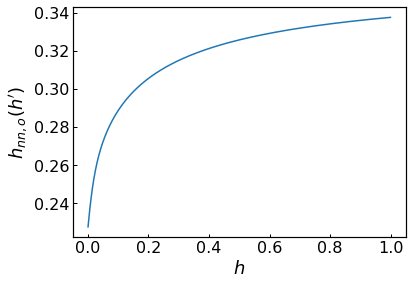

In [5]:
def _hnn_o(h, p_o_hprime_given_h=p_o_hprime_given_h):
    hp = h.reshape( (1,h.shape[0]) )
    return np.sum( hp * p_o_hprime_given_h, axis=1) * (h[1]-h[0])

hnn_o = _hnn_o(h, p_o_hprime_given_h)
plt.xlabel(r"$h$")
plt.ylabel(r"$h_{nn,o}(h')$")
plt.plot(h, hnn_o)

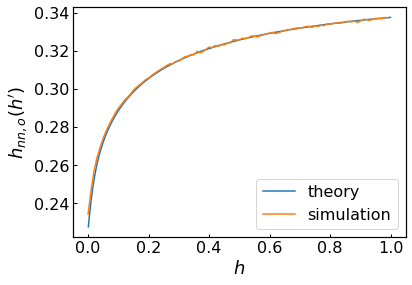

In [6]:
# compare with simulation
def _compare_hnn_o(h, hnn_o):
    result_dir = "/Users/murase/work/oacis/public/Result_development/5c2418e9d12ac60ab25e4d73/5c241925d12ac60a5ec43e3f/5c2425e4d12ac60a582930e2/"
    dat = np.loadtxt(result_dir+"fnn_org.dat")
    plt.xlabel(r"$h$")
    plt.ylabel(r"$h_{nn,o}(h')$")
    plt.plot(h, hnn_o, label="theory")
    plt.plot(dat[:,0], dat[:,1], label="simulation")
    plt.legend()

_compare_hnn_o(h, hnn_o)

100.00000000000134

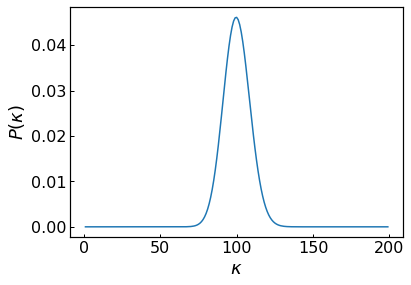

In [7]:
def _p_kappa(kappa, N_in=100, p_in=0.5, N_out=9900, p_out=50.0/9900.0):
    # P(kappa) = \sum_{k_{in}} P_{in}(k_{in})*P_{out}(k_{out})
    # convolution of two binomial distributions
    kappa_in = np.arange(0,200).reshape( (1,200) )
    b_in = binom(N_in, p_in)
    # kappa, kappa_in are axis0,1
    P_in = b_in.pmf(kappa_in)
    b_out = binom(N_out, p_out)
    kappa_out = kappa.reshape( (kappa.shape[0],1) ) - kappa_in   # two-dim array
    P_out = np.where( kappa_out >= 0, b_out.pmf(kappa_out), 0)
    P = np.sum( P_in * P_out, axis=1 )
    return P / np.sum(P)   # normalize to reduce error

kappa = np.arange(1,200)
P_kappa = _p_kappa(kappa)
plt.xlabel(r"$\kappa$")
plt.ylabel(r"$P(\kappa)$")
plt.plot(kappa,P_kappa)

np.sum(kappa*P_kappa)

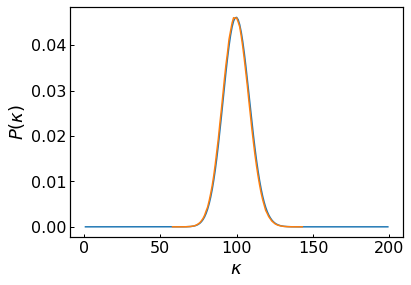

In [8]:
def _compare_p_kappa():
    plt.xlabel(r"$\kappa$")
    plt.ylabel(r"$P(\kappa)$")
    result_dir = "/Users/murase/work/oacis/public/Result_development/5c2418e9d12ac60ab25e4d73/5c241925d12ac60a5ec43e3f/5c2425e4d12ac60a582930e4/"
    dat = np.loadtxt(result_dir+"degree_distribution_ave.dat")
    plt.plot(kappa,P_kappa)
    plt.plot(dat[:,0],dat[:,1]/10000)
    
_compare_p_kappa()

In [9]:
def gen_mean(x,y,beta):  # when beta<=-10 or >=10, minimum or maximum is used
    if beta == 0:
        return np.sqrt(x*y)
    elif beta <= -10:
        return np.minimum(x,y)
    elif beta >= 10:
        return np.maximum(x,y)
    else:
        return ((x**beta+y**beta)/2)**(1.0/beta)

r = lambda x, y: gen_mean(x,y,-10)

r(1.0,3.0)

1.0

In [10]:
class NodalSamplingCorrelatedH:
    
    def __init__(self, h, kappa, rho_h, p_o_hprime_given_h, P_kappa, r):
        self.h = h
        self.nh = h.shape[0]
        self.dh = self.h[1]-self.h[0]
        self.kappa = kappa
        self.nkappa = kappa.shape[0]
        self.rho_h = rho_h
        self.p_o_hprime_given_h = p_o_hprime_given_h   # p_o(h|h')
        assert( rho_h.shape == h.shape )
        self.P_kappa = P_kappa
        assert( P_kappa.shape == kappa.shape )
        self.r = r
        self.k = np.arange(0, np.amax(self.kappa)+1)
        self.nk = self.k.shape[0]
        self.results = {
            "r_bar_h": None,
            "r_bar": None,
            "g": None,
            "P_k": None,
            "r_nn_h": None,
            "p_hprime_given_h": None,
            "c_h": None,
            "g_star": None
        }
        
    def r_bar_h(self):
        # sum_{h'} p_o(h'|h) r(h,h')
        # axis-0,1 are h, h'
        if self.results["r_bar_h"] is not None:
            return self.results["r_bar_h"]
        h_prime = np.copy(self.h).reshape([1,self.nh])
        h_ = self.h.reshape( [self.nh,1] )
        rhh = self.r(h_, h_prime)
        dr = rhh*self.p_o_hprime_given_h*self.dh
        self.results["r_bar_h"] = np.sum(dr,axis=1)
        return self.results["r_bar_h"]
    
    def r_bar(self):
        # sum_{h,h'} \bar{r}(h) rho(h)
        if self.results["r_bar"] is not None:
            return self.results["r_bar"]
        y = self.r_bar_h() * self.rho_h * self.dh
        self.results["r_bar"] = np.sum(y)
        return self.results["r_bar"]
    
    def g(self):
        # g(k|h,kappa) = \binom(kappa, k) r(h)^k ( 1-r(h))^{kappa-k}
        #   k,h,kappa are 0th,1st,2nd axis, respectively
        if self.results["g"] is not None:
            return self.results["g"]
        _p = self.r_bar_h().reshape([1,self.nh,1])
        _kappa = self.kappa.reshape([1,1,self.nkappa])
        b = binom(_kappa, _p)
        _k = self.k.reshape([self.nk,1,1])
        self.results["g"] = b.pmf(_k)
        return self.results["g"]
    
    def P_k(self):
        if self.results["P_k"] is not None:
            return self.results["P_k"]
        _g = self.g() * self.rho_h.reshape([1,self.nh,1]) * self.P_kappa.reshape([1,1,self.nkappa])
        self.results["P_k"] = np.sum(_g, axis=(1,2)) * self.dh
        return self.results["P_k"]

    def r_nn_h(self):
        # h, h_prime are axis=0,1, respectively.
        if self.results["r_nn_h"] is not None:
            return self.results["r_nn_h"]
        r_bar_h_prime = self.r_bar_h().reshape([1,self.nh])
        p_hprime_given_h = self._p_hprime_given_h()
        x = p_hprime_given_h * r_bar_h_prime
        self.results["r_nn_h"] = np.sum( x, axis=1 ) * self.dh
        return self.results["r_nn_h"]
    
    def k_nn_k(self, kappa_nn):
        # k, h, kappa are axis=0,1,2, respectively
        assert( kappa_nn.shape == self.kappa.shape )
        r_nn_h_ = self.r_nn_h().reshape( [1,self.nh,1] )
        kappa_nn_ = kappa_nn.reshape( [1,1,self.nkappa] )
        return 1 + np.sum( self.g_star() * r_nn_h_ * (kappa_nn_-1), axis=(1,2) ) * self.dh;
    
    def _p_hprime_given_h(self):
        # h,h' are axis-0,1
        # p(h'|h) = r(h',h) p_o(h'|h) / r_bar(h)
        if self.results["p_hprime_given_h"] is not None:
            return self.results["p_hprime_given_h"]
        h_ = self.h.reshape( (self.nh,1) )
        h_prime = self.h.reshape( (1,self.nh) )
        rbar_h = self.r_bar_h().reshape( (self.nh,1) )
        self.results["p_hprime_given_h"] = r(h_, h_prime) * self.p_o_hprime_given_h / rbar_h
        return self.results["p_hprime_given_h"]
    
    def h_nn_h(self):
        # h, h_prime are axis=0,1, respectively.
        h_prime = self.h.reshape( (1,self.h.shape[0]) )
        return np.sum( self._p_hprime_given_h() * h_prime, axis=1 ) * self.dh
    
    def c_h(self):
        # h, h', h'' are axis-0,1,2, respectively
        # \sum_{h', h''} = r(h', h'') * p(h'|h) * p(h''|h)
        if self.results["c_h"] is not None:
            return self.results["c_h"]
        nh = self.nh
        h_ = self.h.reshape( (nh,1,1) )
        h_prime = self.h.reshape( (1,nh,1) )
        h_prime2 = self.h.reshape( (1,1,nh) )
        p_hprime_given_h_ = self._p_hprime_given_h().reshape( (nh,nh,1) )
        p_hprime2_given_h_ = self._p_hprime_given_h().reshape( (nh,1,nh) )
        r_ = self.r(h_prime, h_prime2).reshape( (1,nh,nh) )
        self.results["c_h"] = np.sum( r_ * p_hprime_given_h_ * p_hprime2_given_h_, axis=(1,2) ) * self.dh * self.dh
        return self.results["c_h"]
    
    def c_k(self, c_o_kappa):
        # k, h, kappa are axis-0,1,2, respectively
        # 1/P(k) * \sum_{h,\kappa} g(k|h,\kappa) rho(h) P(\kappa) c_h c_o(\kappa)
        _c_o_kappa = c_o_kappa.reshape( (1,1,self.nkappa) )
        _rho_h = self.rho_h.reshape( (1,self.nh,1) )
        _p_kappa = self.P_kappa.reshape( (1,1,self.nkappa) )
        _c_h = self.c_h().reshape( (1,self.nh,1) )
        return 1.0 / self.P_k() * np.sum( self.g() * _rho_h * _p_kappa * _c_h * _c_o_kappa, axis=(1,2) ) * self.dh

    def g_star(self):
        # g*(h,kappa|k) = g(k|h,kappa)rho(h)P_o(kappa) / P(k)
        if self.results["g_star"] is not None:
            return self.results["g_star"]
        Pk = self.P_k()
        Pk_ = Pk[ Pk > 0 ]
        Pk_ = Pk_.reshape( [Pk_.shape[0],1,1,] )
        _g = self.g()[Pk > 0,:,:]
        rho_h_ = self.rho_h.reshape( [1,self.nh,1] )
        p_kappa_ = self.P_kappa.reshape( [1,1,self.nkappa] )
        self.results["g_star"] = _g / Pk_ * rho_h_ * p_kappa_
        return self.results["g_star"]

        
sampling_co = NodalSamplingCorrelatedH(h=h, kappa=kappa, rho_h=rho, p_o_hprime_given_h=p_o_hprime_given_h, P_kappa=P_kappa, r=r)


In [11]:
class NodalSampling:
    
    # Only r_bar_h, and _p_hprime_given_h are different from correlated case.
    
    def __init__(self, h, kappa, rho_h, P_kappa, r):
        self.h = h
        self.nh = h.shape[0]
        self.dh = self.h[1]-self.h[0]
        self.kappa = kappa
        self.nkappa = kappa.shape[0]
        self.rho_h = rho_h
        assert( rho_h.shape == h.shape )
        self.P_kappa = P_kappa
        assert( P_kappa.shape == kappa.shape )
        self.r = r
        self.k = np.arange(0, np.amax(self.kappa)+1)
        self.nk = self.k.shape[0]
        self.results = {
            "r_bar_h": None,
            "r_bar": None,
            "g": None,
            "P_k": None,
            "r_nn_h": None,
            "p_hprime_given_h": None,
            "c_h": None,
            "g_star": None
        }
        
    def r_bar_h(self):
        # sum_{h'} rho(h') r(h,h')
        # axis-0,1 are h, h'
        if self.results["r_bar_h"] is not None:
            return self.results["r_bar_h"]
        h_prime = np.copy(self.h).reshape([1,self.nh])
        h_ = self.h.reshape( [self.nh,1] )
        rhh = self.r(h_, h_prime)
        dr = rhh*rho.reshape([1,self.nh])*self.dh
        self.results["r_bar_h"] = np.sum(dr,axis=1)
        return self.results["r_bar_h"]
    
    def r_bar(self):
        # sum_{h,h'} \bar{r}(h) rho(h)
        if self.results["r_bar"] is not None:
            return self.results["r_bar"]
        y = self.r_bar_h() * self.rho_h * self.dh
        self.results["r_bar"] = np.sum(y)
        return self.results["r_bar"]
    
    def g(self):
        # g(k|h,kappa) = \binom(kappa, k) r(h)^k ( 1-r(h))^{kappa-k}
        #   k,h,kappa are 0th,1st,2nd axis, respectively
        if self.results["g"] is not None:
            return self.results["g"]
        _p = self.r_bar_h().reshape([1,self.nh,1])
        _kappa = self.kappa.reshape([1,1,self.nkappa])
        b = binom(_kappa, _p)
        _k = self.k.reshape([self.nk,1,1])
        self.results["g"] = b.pmf(_k)
        return self.results["g"]
    
    def P_k(self):
        if self.results["P_k"] is not None:
            return self.results["P_k"]
        _g = self.g() * self.rho_h.reshape([1,self.nh,1]) * self.P_kappa.reshape([1,1,self.nkappa])
        self.results["P_k"] = np.sum(_g, axis=(1,2)) * self.dh
        return self.results["P_k"]

    def r_nn_h(self):
        # h, h_prime are axis=0,1, respectively.
        if self.results["r_nn_h"] is not None:
            return self.results["r_nn_h"]
        r_bar_h_prime = self.r_bar_h().reshape([1,self.nh])
        p_hprime_given_h = self._p_hprime_given_h()
        x = p_hprime_given_h * r_bar_h_prime
        self.results["r_nn_h"] = np.sum( x, axis=1 ) * self.dh
        return self.results["r_nn_h"]
    
    def k_nn_k(self, kappa_nn):
        # k, h, kappa are axis=0,1,2, respectively
        assert( kappa_nn.shape == self.kappa.shape )
        r_nn_h_ = self.r_nn_h().reshape( [1,self.nh,1] )
        kappa_nn_ = kappa_nn.reshape( [1,1,self.nkappa] )
        return 1 + np.sum( self.g_star() * r_nn_h_ * (kappa_nn_-1), axis=(1,2) ) * self.dh;
    
    def _p_hprime_given_h(self):
        # h,h' are axis-0,1
        # p(h'|h) = r(h',h) rho(h') / r_bar(h)
        if self.results["p_hprime_given_h"] is not None:
            return self.results["p_hprime_given_h"]
        h_ = self.h.reshape( (self.nh,1) )
        h_prime = self.h.reshape( (1,self.nh) )
        rho_hprime = self.rho_h.reshape( (1,self.nh) )
        rbar_h = self.r_bar_h().reshape( (self.nh,1) )
        self.results["p_hprime_given_h"] = r(h_, h_prime) * rho_hprime / rbar_h
        return self.results["p_hprime_given_h"]
    
    def h_nn_h(self):
        # h, h_prime are axis=0,1, respectively.
        h_prime = self.h.reshape( (1,self.h.shape[0]) )
        return np.sum( self._p_hprime_given_h() * h_prime, axis=1 ) * self.dh
    
    def c_h(self):
        # h, h', h'' are axis-0,1,2, respectively
        # \sum_{h', h''} = r(h', h'') * p(h'|h) * p(h''|h)
        if self.results["c_h"] is not None:
            return self.results["c_h"]
        nh = self.nh
        h_ = self.h.reshape( (nh,1,1) )
        h_prime = self.h.reshape( (1,nh,1) )
        h_prime2 = self.h.reshape( (1,1,nh) )
        p_hprime_given_h_ = self._p_hprime_given_h().reshape( (nh,nh,1) )
        p_hprime2_given_h_ = self._p_hprime_given_h().reshape( (nh,1,nh) )
        r_ = self.r(h_prime, h_prime2).reshape( (1,nh,nh) )
        self.results["c_h"] = np.sum( r_ * p_hprime_given_h_ * p_hprime2_given_h_, axis=(1,2) ) * self.dh * self.dh
        return self.results["c_h"]
    
    def c_k(self, c_o_kappa):
        # k, h, kappa are axis-0,1,2, respectively
        # 1/P(k) * \sum_{h,\kappa} g(k|h,\kappa) rho(h) P(\kappa) c_h c_o(\kappa)
        _c_o_kappa = c_o_kappa.reshape( (1,1,self.nkappa) )
        _rho_h = self.rho_h.reshape( (1,self.nh,1) )
        _p_kappa = self.P_kappa.reshape( (1,1,self.nkappa) )
        _c_h = self.c_h().reshape( (1,self.nh,1) )
        return 1.0 / self.P_k() * np.sum( self.g() * _rho_h * _p_kappa * _c_h * _c_o_kappa, axis=(1,2) ) * self.dh

    def g_star(self):
        # g*(h,kappa|k) = g(k|h,kappa)rho(h)P_o(kappa) / P(k)
        if self.results["g_star"] is not None:
            return self.results["g_star"]
        Pk = self.P_k()
        Pk_ = Pk[ Pk > 0 ]
        Pk_ = Pk_.reshape( [Pk_.shape[0],1,1,] )
        _g = self.g()[Pk > 0,:,:]
        rho_h_ = self.rho_h.reshape( [1,self.nh,1] )
        p_kappa_ = self.P_kappa.reshape( [1,1,self.nkappa] )
        self.results["g_star"] = _g / Pk_ * rho_h_ * p_kappa_
        return self.results["g_star"]
    
sampling_uc = NodalSampling(h=h, kappa=kappa, rho_h=rho, P_kappa=P_kappa, r=r)

0.16401105731500687 0.15475160165260904


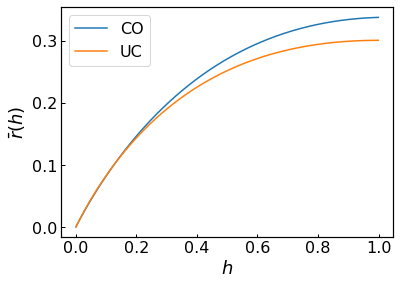

In [12]:
plt.xlabel(r"$h$")
plt.ylabel(r"$\bar{r}(h)$")
plt.plot(h, sampling_co.r_bar_h(), label="CO")
plt.plot(h, sampling_uc.r_bar_h(), label="UC")
plt.legend()
print(sampling_co.r_bar(), sampling_uc.r_bar())

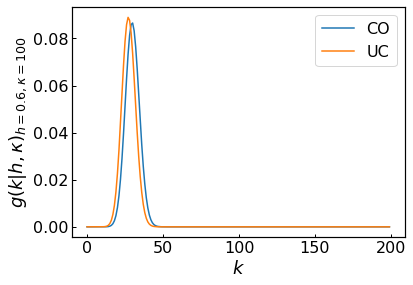

In [13]:
plt.xlabel(r"$k$")
plt.ylabel(r"$g(k|h,\kappa)_{h=0.6,\kappa=100}$")
plt.plot(sampling_co.k, sampling_co.g()[:,300,100], label="CO")
plt.plot(sampling_uc.k, sampling_uc.g()[:,300,100], label="UC")
plt.legend()

(16.40110573150062, 15.47516016526085)

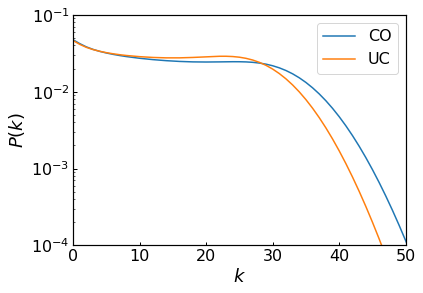

In [14]:
plt.yscale("log")
plt.ylim(1.0e-4,1.0e-1)
plt.xlim(0,50)
plt.xlabel(r"$k$")
plt.ylabel(r"$P(k)$")
plt.plot( sampling_co.k, sampling_co.P_k(), label="CO" )
plt.plot( sampling_uc.k, sampling_uc.P_k(), label="UC" )
plt.legend()

sampling_co.P_k() - sampling_uc.P_k()
np.sum( sampling_co.k*sampling_co.P_k() ), np.sum( sampling_uc.k*sampling_uc.P_k() )

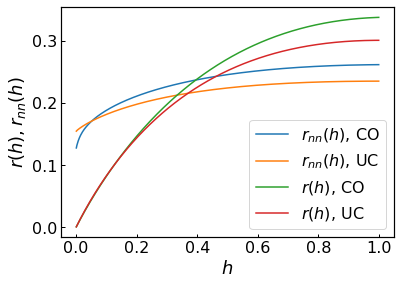

In [15]:
plt.xlabel(r"$h$")
plt.ylabel(r"$r(h), r_{nn}(h)$")
plt.plot(sampling_co.h, sampling_co.r_nn_h(), label=r"$r_{nn}(h)$, CO")
plt.plot(sampling_uc.h, sampling_uc.r_nn_h(), label=r"$r_{nn}(h)$, UC")
plt.plot(sampling_co.h, sampling_co.r_bar_h(), label=r"$r(h)$, CO")
plt.plot(sampling_uc.h, sampling_uc.r_bar_h(), label=r"$r(h)$, UC")
plt.legend()

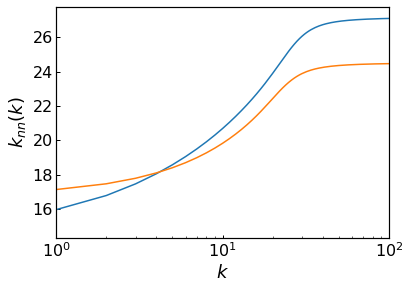

In [16]:
kappa_mean = np.sum(kappa * P_kappa)
kappa_nn = np.full(kappa.shape, kappa_mean + 1)
plt.xscale("log")
plt.xlabel(r"$k$")
plt.ylabel(r"$k_{nn}(k)$")
plt.xlim(1.0e0, 1.0e2)
plt.plot(sampling_co.k, sampling_co.k_nn_k(kappa_nn), label="CO" )
plt.plot(sampling_uc.k, sampling_uc.k_nn_k(kappa_nn), label="UC" )

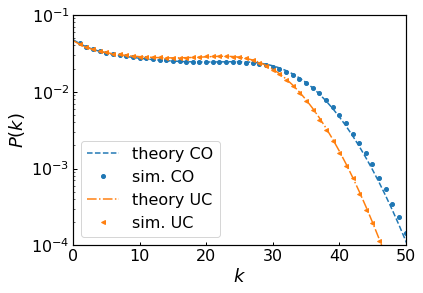

In [17]:
#result_dir_co = "/Users/murase/work/oacis/public/Result_development/5c2418e9d12ac60ab25e4d73/5c241925d12ac60a5ec43e3f/5c2425e4d12ac60a582930e3/"
result_dir_co = "sim_result/fig5/co/"
#result_dir_uc = "/Users/murase/work/oacis/public/Result_development/5c2418e9d12ac60ab25e4d73/5c241925d12ac60a5ec43e40/5c242bd0d12ac60a58293279/"
result_dir_uc = "sim_result/fig5/uc/"
savefig = False

def _compare_Pk(sampling_co, sampling_uc, sim_dir_co, sim_dir_uc):
    f_co = sim_dir_co + "degree_distribution_ave.dat"
    dat_co = np.loadtxt(f_co)
    f_uc = sim_dir_uc + "degree_distribution_ave.dat"
    dat_uc = np.loadtxt(f_uc)
    plt.xlim(0,50)
    plt.ylim(1.0e-4,1.0e-1)
    plt.yscale("log")
    plt.xlabel(r"$k$")
    plt.ylabel(r"$P(k)$")
    plt.plot( sampling_co.k, sampling_co.P_k(), '--', color="#1f77b4", label="theory CO" )
    plt.plot( dat_co[:,0], dat_co[:,1]/10000, 'o', color="#1f77b4", label="sim. CO" )
    plt.plot( sampling_uc.k, sampling_uc.P_k(), '-.', color='#ff7f0e', label="theory UC" )
    plt.plot( dat_uc[:,0], dat_uc[:,1]/10000, "<",color='#ff7f0e', label="sim. UC" )
    plt.legend()
    if savefig:
        plt.savefig("corr_pk_sim.pdf")

_compare_Pk(sampling_co, sampling_uc, result_dir_co, result_dir_uc)

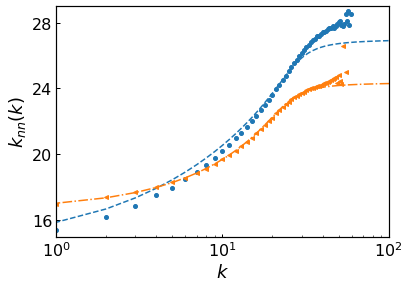

In [18]:
def _compare_knn(sampling_co, sampling_uc, sim_dir_co, sim_dir_uc):
    f = "neighbor_degree_correlation_ave.dat"
    dat_co = np.loadtxt(sim_dir_co+f)
    dat_uc = np.loadtxt(sim_dir_uc+f)
    plt.xscale("log")
    plt.xlabel(r"$k$")
    plt.ylabel(r"$k_{nn}(k)$")
    plt.xlim(1.0e0, 1.0e2)
    plt.yticks( np.arange(16,30,step=4))
    plt.ylim(15,29)
    kappa_mean = np.sum(kappa * P_kappa)
    # kappa_nn is approximated by 100.14+0.001*x
    kappa_nn = np.full(kappa.shape, 100.14) + kappa*0.001
    plt.plot( sampling_co.k, sampling_co.k_nn_k(kappa_nn), '--', color="#1f77b4", label="theory CO" )
    plt.plot( dat_co[:,0], dat_co[:,1], 'o', color="#1f77b4", label="sim. CO" )
    plt.plot( sampling_uc.k, sampling_uc.k_nn_k(kappa_nn), '-.', color='#ff7f0e', label="theory UC" )
    plt.plot( dat_uc[:,0], dat_uc[:,1], "<",color='#ff7f0e', label="sim. UC" )
    # plt.legend()
    if savefig:
        plt.savefig("corr_knn_sim.pdf")
    
_compare_knn(sampling_co, sampling_uc, result_dir_co, result_dir_uc)

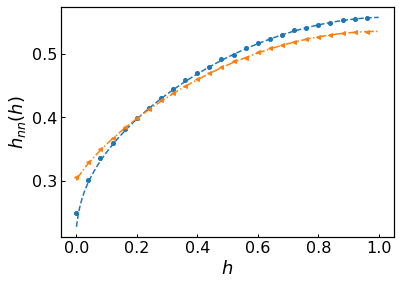

In [19]:
# _fnn_analysis_co = "/Users/murase/work/oacis/public/Result_development/5c2418e9d12ac60ab25e4d73/5c241925d12ac60a5ec43e3f/5c2425e4d12ac60a582930e2/"
_fnn_analysis_co = result_dir_co
# _fnn_analysis_uc = "/Users/murase/work/oacis/public/Result_development/5c2418e9d12ac60ab25e4d73/5c241925d12ac60a5ec43e40/5c242bd0d12ac60a58293278/"
_fnn_analysis_uc = result_dir_uc
 
def _compare_hnn(sampling_co, sampling_uc, sim_dir_co, sim_dir_uc):
    f = "fnn.dat"
    dat_co = np.loadtxt(sim_dir_co+f)
    dat_uc = np.loadtxt(sim_dir_uc+f)
    plt.xlabel(r"$h$")
    plt.ylabel(r"$h_{nn}(h)$")
    plt.plot( sampling_co.h, sampling_co.h_nn_h(), '--', color="#1f77b4", label="theory CO" )
    plt.plot( dat_co[::4,0], dat_co[::4,1], 'o', color="#1f77b4", label="sim. CO" )
    plt.plot( sampling_uc.h, sampling_uc.h_nn_h(), '-.', color='#ff7f0e', label="theory UC" )
    plt.plot( dat_uc[::4,0], dat_uc[::4,1], "<",color='#ff7f0e', label="sim. UC" )
    # plt.legend()
    if savefig:
        plt.savefig("corr_hnn_sim.pdf")
    
_compare_hnn(sampling_co, sampling_uc, _fnn_analysis_co, _fnn_analysis_uc)


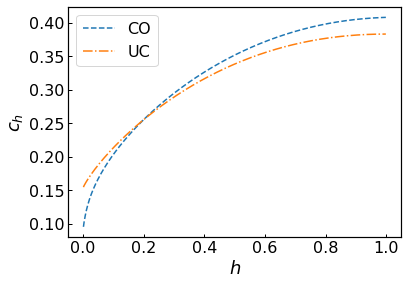

In [20]:
plt.xlabel(r"$h$")
plt.ylabel(r"$c_{h}$")
plt.plot(sampling_co.h, sampling_co.c_h(), "--", label="CO")
plt.plot(sampling_uc.h, sampling_uc.c_h(), "-.", label="UC")
plt.legend()

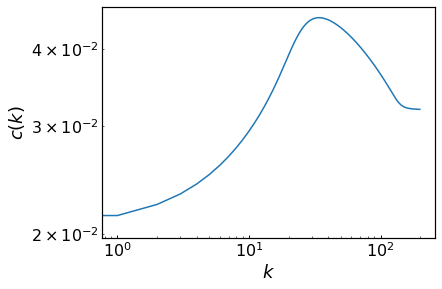

In [21]:
# c_o_kappa is well approximated by -0.00082*x+0.211
# c_o_kappa = kappa * (-0.00082) + np.full( kappa.shape, 0.211 )
c_o_kappa = 2.0 * kappa ** (-0.6)
plt.xscale("log")
plt.yscale("log")
#plt.plot(kappa, c_o_kappa)

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$k$")
plt.ylabel(r"$c(k)$")
plt.plot(sampling_uc.k, sampling_uc.c_k(c_o_kappa))

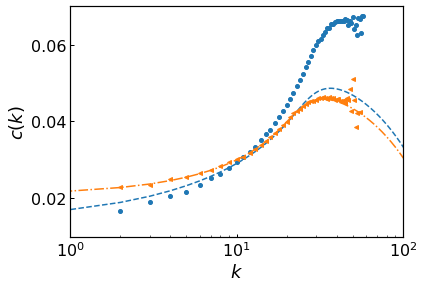

In [22]:
def _compare_ck(sampling_co, sampling_uc, sim_dir_co, sim_dir_uc):
    f = "cc_degree_correlation_ave.dat"
    dat_co = np.loadtxt(sim_dir_co+f)
    dat_uc = np.loadtxt(sim_dir_uc+f)
    plt.xscale("log")
    plt.xlabel(r"$k$")
    plt.ylabel(r"$c(k)$")
    plt.xlim(1.0e0, 1.0e2)
    plt.ylim(0.01,0.07)
    plt.yticks( np.arange(0.02, 0.08, step=0.02))
    c_o_kappa = sampling_co.kappa * (-0.00082) + np.full( sampling_co.kappa.shape, 0.211 )
    plt.plot( sampling_co.k, sampling_co.c_k(c_o_kappa), '--', color="#1f77b4", label="theory CO")
    plt.plot( dat_co[:,0], dat_co[:,1], 'o', color="#1f77b4", label="sim. CO" )
    plt.plot( sampling_uc.k, sampling_uc.c_k(c_o_kappa), '-.', color='#ff7f0e', label="theory UC")
    plt.plot( dat_uc[::,0], dat_uc[::,1], "<",color='#ff7f0e', label="sim. UC" )
    # plt.legend()
    if savefig:
        plt.savefig("corr_ck_sim.pdf")
    
_compare_ck(sampling_co, sampling_uc, result_dir_co, result_dir_uc)
